In [1010]:
import os
import time
import sys
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid, kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree, cKDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from concorde.tsp import TSPSolver
from math import sqrt, ceil, inf, floor
from collections import Counter, defaultdict

In [1011]:
root_dir = os.getcwd()
tsp_dir = os.path.join(root_dir, "../tsplib")
print(tsp_dir)
concorde_dir = os.path.join(root_dir, "../pyconcorde/concorde")

/Users/amodholla/Desktop/ISING-MAC/Large-Scale-Ising/../tsplib


In [1012]:
sys.path.insert(0, root_dir)
sys.path.insert(0, tsp_dir)
#sys.path.insert(0, concorde_dir)

In [1013]:
num_samples = 10000

In [1014]:
def gen_tsp_data():
    ## Load a tsp library and Create a dictionary "tsp_database" of Name-X/Y coordinates.

    tsp_database = {}
    cities = os.listdir(tsp_dir)
    
    for city in cities:
        if city.endswith(".tsp"):
            with open(tsp_dir + '/' + city, 'r') as infile:
                lines = infile.readlines()
                for i in range(0, len(lines)):
                    line = lines[i]
                    if "DIMENSION" in line:
                        Dimension = line.strip().split(':')[1]
                        if not Dimension.isdigit():
                            continue
                    if "EDGE_WEIGHT_TYPE" in line:
                        EdgeWeightType = line.strip().split()[1]
                        if EdgeWeightType != "EUC_2D":
                            continue
                    if "NODE_COORD_SECTION" in line:
                        x_y = None
                        nodelist_x = []
                        nodelist_y = []
        
                        for j in range (1, int(Dimension)):
                            x_y = lines[i+1].strip().split()[1:]
    #                        print(x_y)
    #                        import pdb; pdb.set_trace()
                            x = x_y[0]
                            y = x_y[1]
                            nodelist_x.append(float(x))
                            nodelist_y.append(float(y))
                            i+=1
                        tsp_database.update({city[:-4]:[nodelist_x, nodelist_y]})
    return tsp_database    

In [1015]:
tsp_database = gen_tsp_data()
problem_list = tsp_database.keys()
problem_list

dict_keys(['pr439', 'pla7397', 'gr96', 'rd100', 'rl5934', 'pcb442', 'u2319', 'gil262', 'pcb3038', 'lin105', 'fl417', 'tsp225', 'fl1400', 'nrw1379', 'd2103', 'kroA150', 'pcb1173', 'd198', 'fl1577', 'gr666', 'ch130', 'kroB100', 'u1060', 'berlin52', 'eil51', 'rl1304', 'u2152', 'ulysses16', 'u724', 'kroD100', 'linhp318', 'pr299', 'rd400', 'gr202', 'vm1084', 'rat575', 'd1655', 'ch150', 'd15112', 'pr107', 'kroB200', 'brd14051', 'a280', 'd1291', 'gr229', 'pr264', 'pr76', 'd493', 'dsj1000', 'pr136', 'rat195', 'rl11849', 'att532', 'kroA100', 'pla85900', 'ali535', 'ulysses22', 'kroB150', 'bier127', 'kroC100', 'usa13509', 'eil76', 'pr124', 'rl1323', 'p654', 'gr431', 'rl1889', 'd657', 'eil101', 'fnl4461', 'pr2392', 'rat783', 'ts225', 'u1432', 'u1817', 'lin318', 'd18512', 'rl5915', 'att48', 'st70', 'rat99', 'fl3795', 'burma14', 'u159', 'pla33810', 'kroA200', 'u574', 'pr1002', 'pr152', 'gr137', 'pr226', 'vm1748', 'pr144', 'kroE100'])

Problem : eil51


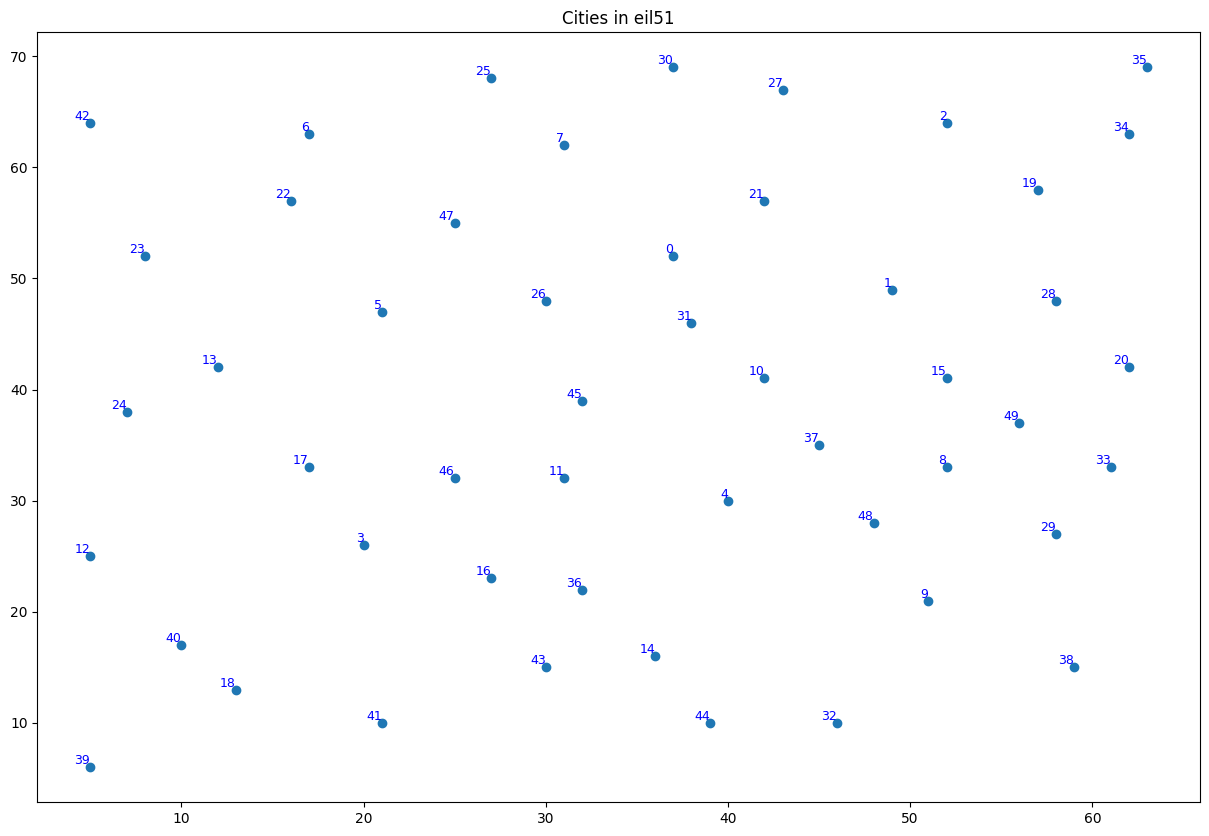

In [1016]:
import pyproj as p

x = "eil51"

coord_geo = False
if coord_geo == True:
     crs_wgs = p.Proj(init='epsg:4326')
     crs_bng = p.Proj(init = 'epsg:27700')
    
     tsp_database[x][0],tsp_database[x][1]  = p.transform(crs_wgs, crs_bng, tsp_database[x][1], tsp_database[x][0])
# for x in tsp_database:
print("Problem : " + x)
#    print(tsp_database[x])
X_coord = np.array(tsp_database[x][0])
Y_coord = np.array(tsp_database[x][1])
X_Y = np.array(list(zip(X_coord,Y_coord))).reshape(len(X_coord),2)
plt.figure(figsize=(15,10))
plt.plot()
plt.title('Cities in ' + x)
plt.scatter(X_coord, Y_coord)
for idx, (x1, y1) in enumerate(X_Y):
    plt.text(x1, y1, str(idx), fontsize=9, ha='right', va='bottom', color='blue')
plt.show()


lt.plot()<br>
lt.title('Cities in ' + x)<br>
lt.scatter(X_coord, Y_coord)<br>
lt.show()

In [1017]:
from numpy import inf

X_Y[X_Y == inf] = 0

In [1018]:
def nearest_two_points(X_Y):
    # for each point in X_Y, find the nearest 2 points.
    distances = np.linalg.norm(X_Y[:, np.newaxis, :] - X_Y[np.newaxis, :, :], axis=-1)

    # For each point, find the indices of the 2 smallest non-zero distances
    closest_points = []
    for i in range(len(X_Y)):
        # Exclude the point itself by setting its distance to infinity
        distances[i, i] = np.inf
        # Get the indices of the 2 closest points
        closest_indices = np.argsort(distances[i])[:2]
        closest_points.append(closest_indices)

    closest_points = np.array(closest_points)

    return closest_points

In [1019]:
def check_line_intersection(p1, p2, x_ref, y_ref):
    # given two points p1 and p2, the function returns if the line joining them crosses x_ref or y_ref first 
    # helper function for generate_transit_points
    x1, y1 = p1
    x2, y2 = p2
    '''
    print(x1, y1, x2, y2)
    print(x_ref, y_ref)
    '''
    # Initialize t_x and t_y to None
    t_x = t_y = None
    
    # Compute t_x (intersection with x = x_ref)
    if x2 != x1:  # Avoid division by zero (vertical line)
        t_x = (x_ref - x1) / (x2 - x1)
    
    # Compute t_y (intersection with y = y_ref)
    if y2 != y1:  # Avoid division by zero (horizontal line)
        t_y = (y_ref - y1) / (y2 - y1)
    
    # Determine which line is crossed first
    if t_x is not None and 0 <= t_x <= 1:
        if t_y is not None and 0 <= t_y <= 1:
            return 1 if t_x < t_y else 0
        return 1
    elif t_y is not None and 0 <= t_y <= 1:
        return 0
    else:
        raise ValueError("The line segment does not cross either x_ref or y_ref.")

In [1020]:
import numpy as np

def divide_into_quadrants_with_deviation(global_X_Y, X_Y, transit_point_master, transit_info_master):
    # Map transit points and filter those existing in X_Y
    valid_transit_points = []
    valid_transit_info = []
    for i, index in enumerate(transit_point_master):
        global_point = global_X_Y[index[0]]
        if any((global_point == x).all() for x in X_Y):
            valid_transit_points.append(global_point)
            valid_transit_info.append(transit_info_master[i])
    valid_transit_points = np.array(valid_transit_points)
    valid_transit_info = np.array(valid_transit_info)

    # Calculate initial mean split
    mean_split = np.mean(X_Y, axis=0)

    # Adjust y-axis split
    x_crossing_points = valid_transit_points[valid_transit_info == 1]
    deviation = 0.1
    left_deviation_y, right_deviation_y = mean_split[1], mean_split[1]
    flag_left = 0
    flag_right = 0
    while True:
        left_y_split = mean_split[1] - deviation
        right_y_split = mean_split[1] + deviation
        left_even = np.sum(x_crossing_points[:, 1] < left_y_split) % 2 == 0
        right_even = np.sum(x_crossing_points[:, 1] < right_y_split) % 2 == 0
        if left_even:
            left_deviation_y = left_y_split
            flag_left = 1
        if right_even:
            right_deviation_y = right_y_split
            flag_right = 1
        if left_even or right_even:
            break
        deviation += 0.1
    
    if flag_left==1 and flag_right==1:
        y_deviation_left = abs(mean_split[1] - left_deviation_y)
        y_deviation_right = abs(mean_split[1] - right_deviation_y)
        best_y_split = left_deviation_y if y_deviation_left <= y_deviation_right else right_deviation_y
    elif flag_left == 1:
        best_y_split = left_deviation_y
    else:
        best_y_split = right_deviation_y

    # Adjust x-axis split similarly
    y_crossing_points = valid_transit_points[valid_transit_info == 0]
    deviation = 0.1
    left_deviation_x, right_deviation_x = mean_split[0], mean_split[0]
    flag_left = 0
    flag_right = 0
    while True:
        left_x_split = mean_split[0] - deviation
        right_x_split = mean_split[0] + deviation
        left_even = np.sum(y_crossing_points[:, 0] < left_x_split) % 2 == 0
        right_even = np.sum(y_crossing_points[:, 0] < right_x_split) % 2 == 0
        if left_even:
            left_deviation_x = left_x_split
            flag_left = 1
        if right_even:
            right_deviation_x = right_x_split
            flag_right = 1
        if left_even or right_even:
            break
        deviation += 0.1
    
    if flag_left==1 and flag_right==1:
        x_deviation_left = abs(mean_split[1] - left_deviation_x)
        x_deviation_right = abs(mean_split[1] - right_deviation_x)
        best_x_split = left_deviation_x if x_deviation_left <= x_deviation_right else right_deviation_x
    elif flag_left == 1:
        best_x_split = left_deviation_x
    else:
        best_x_split = right_deviation_x

    '''
    # Choose shortest deviations for both axes
    x_deviation_left = abs(mean_split[0] - left_deviation_x)
    x_deviation_right = abs(mean_split[0] - right_deviation_x)
    y_deviation_left = abs(mean_split[1] - left_deviation_y)
    y_deviation_right = abs(mean_split[1] - right_deviation_y)
    

    best_x_split = left_deviation_x if x_deviation_left <= x_deviation_right else right_deviation_x
    best_y_split = left_deviation_y if y_deviation_left <= y_deviation_right else right_deviation_y
    '''

    '''
    #print(best_x_split, best_y_split)
    print('END')

    plt.figure()
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    plt.scatter(X_Y[:, 0], X_Y[:, 1], s=2)
    plt.scatter(valid_transit_points[valid_transit_info==1][:, 0], valid_transit_points[valid_transit_info==1][:, 1], c='r', s=2)
    plt.scatter(valid_transit_points[valid_transit_info==0][:, 0], valid_transit_points[valid_transit_info==0][:, 1], c='black', s=2)
    plt.axvline(x=best_x_split)
    plt.axhline(y=best_y_split)
    '''

    return best_x_split, best_y_split

In [1021]:
def find_closest_pairs_indices(set1, set2):
        indices1, points1 = zip(*set1)
        indices2, points2 = zip(*set2)
        points1 = np.array(points1)
        points2 = np.array(points2)

        distances = np.linalg.norm(points1[:, None] - points2[None, :], axis=2)  # Pairwise distances
        pairs = []
        for _ in range(2):  # Find two closest pairs
            min_idx = np.unravel_index(np.argmin(distances), distances.shape)
            pairs.append((indices1[min_idx[0]], indices2[min_idx[1]], distances[min_idx]))
            distances[min_idx[0], :] = np.inf  # Exclude this point
            distances[:, min_idx[1]] = np.inf
        return pairs

def find_closest_indices(global_X_Y, partition, id, x_partition, xid, y_partition, yid,  transit_point_master):
    # Extract the excluded points based on global_X_Y
    #TODO needs to be improved
    excluded_points = set(tuple(global_X_Y[sublist[0]]) for sublist in transit_point_master)
    
    #frequency = Counter(sublist[0] for sublist in transit_point_master)
    # Create the set of excluded points for elements that appear exactly twice
    #excluded_points = set(tuple(global_X_Y[sublist[0]]) for sublist in transit_point_master if frequency[sublist[0]] == 2)
    
    # Filter out excluded points and map them to global_X_Y indices
    filtered_partition = [
        (int(np.where((global_X_Y == pt).all(axis=1))[0][0]), pt)
        for pt in partition if tuple(pt) not in excluded_points
    ]
    filtered_x_partition = [
        (int(np.where((global_X_Y == pt).all(axis=1))[0][0]), pt)
        for pt in x_partition if tuple(pt) not in excluded_points
    ]
    filtered_y_partition = [
        (int(np.where((global_X_Y == pt).all(axis=1))[0][0]), pt)
        for pt in y_partition if tuple(pt) not in excluded_points
    ]

    # Ensure there are valid points
    if not filtered_partition or (not filtered_x_partition and not filtered_y_partition):
        raise ValueError("No valid points remaining after filtering.")
    
    # Find closest pairs for both partition - x_partition and partition - y_partition
    pairs_x = find_closest_pairs_indices(filtered_partition, filtered_x_partition) if filtered_x_partition else []
    pairs_y = find_closest_pairs_indices(filtered_partition, filtered_y_partition) if filtered_y_partition else []

    # Compute total distance for each set of pairs
    total_distance_x = sum(pair[2] for pair in pairs_x) if pairs_x else np.inf
    total_distance_y = sum(pair[2] for pair in pairs_y) if pairs_y else np.inf

    # Choose the shortest set of pairs and return the global_X_Y indices
    if total_distance_x < total_distance_y:
        return [list((pair[0], pair[1], int(str(id) + str(xid)))) for pair in pairs_x]  # Indices of partition and x_partition in global_X_Y
    else:
        return [list((pair[0], pair[1], int(str(id) + str(yid)))) for pair in pairs_y]  # Indices of partition and y_partition in global_X_Y

In [1022]:
import copy


def generate_transit_points(global_X_Y, X_Y, transit_point_master, transit_info_master, reference_frame, ising_size = 12):
    '''
    Splits the grid of given points into 4 (vertical line parallel to y-axis, and a horizontal line parallel to x-axis), and generates
    transit points between the 4 quadrants.
    The logic for whether a point is a transit point is as follows:
    After splitting the graph, calculate the distance to the closest 2 points. If one of the points is in the other quadrant, then it is a transit point.
    Make sure number of transit points are even?
    
    transit points is a list (np array) that contains a list/np.array of links [p1, p2] between quadrants (p1 and p2 are indices in X_Y)
    '''
  
    if transit_point_master == []:
        # Find the midpoint of the graph along x and y axis
        x_mid = np.mean(X_Y[:,0])
        y_mid = np.mean(X_Y[:,1])
        
        
    else:
        x_mid, y_mid = divide_into_quadrants_with_deviation(global_X_Y, X_Y, transit_point_master, transit_info_master)
   
    #x_mid = np.mean(X_Y[:,0])
    #y_mid = np.mean(X_Y[:,1])

    #Split the graph into 4 quadrants, give an ID to each point based on which quadrant it belongs to.
    quadrant_id = np.zeros(len(X_Y))
    
    quadrant_id[(X_Y[:,0] > x_mid) & (X_Y[:,1] > y_mid)] = 1
    quadrant_id[(X_Y[:,0] <= x_mid) & (X_Y[:,1] > y_mid)] = 2
    quadrant_id[(X_Y[:,0] <= x_mid) & (X_Y[:,1] <= y_mid)] = 3
    quadrant_id[(X_Y[:,0] > x_mid) & (X_Y[:,1] <= y_mid)] = 4
    
    print(quadrant_id)
    
 
    if len(X_Y) == 1:
        print('Not enough points')
        return [([X_Y], [True])], None, transit_point_master, X_Y[0][0], X_Y[0][1]
    
  
    # Find the closest 2 points for each point
    closest_points = nearest_two_points(X_Y)
    
    
    #For each point in X_Y, check if the closest 2 points are in the same quadrant or not.
    #If not, then it is a transit point.
    transit_points = []
    point_freq = {}
    for i in range(len(X_Y)):
        
        p1 = p2 = -1
        if quadrant_id[closest_points[i][0]] != quadrant_id[i] or quadrant_id[closest_points[i][1]] != quadrant_id[i]:
            p1 = i
            if i in point_freq:
                point_freq[i] += 1
            else:
                point_freq[i] = 1
            #identify if the closest or second closest is in the other quadrant
            if quadrant_id[closest_points[i][0]] != quadrant_id[i]:
                p2 = closest_points[i][0]
                if closest_points[i][0] in point_freq:
                    point_freq[closest_points[i][0]] += 1
                else:   
                    point_freq[closest_points[i][0]] = 1
            elif quadrant_id[closest_points[i][1]] != quadrant_id[i]:
                if closest_points[i][1] in point_freq:
                    point_freq[closest_points[i][1]] += 1
                else:
                    point_freq[closest_points[i][1]] = 1
                p2 = closest_points[i][1]
        if p1 == -1 and p2 == -1:
            #calculate distance of xmid and ymid from the point
            d_xmid = abs(X_Y[i, 0] - x_mid)
            d_ymid = abs(X_Y[i, 1] - y_mid)
            #if the 2 closest points are on the same side of the point with respect to the smaller of d_xmid and d_ymid:
            if d_ymid<d_xmid:
                if (X_Y[i, 1] - X_Y[closest_points[i][0], 1]) * (X_Y[i, 1] - y_mid) < 0 and (X_Y[i, 1] - X_Y[closest_points[i][1], 1]) * (X_Y[i, 1] - y_mid) < 0 and d_ymid < max(np.linalg.norm(X_Y[i] - X_Y[closest_points[i][0]]), np.linalg.norm(X_Y[i] - X_Y[closest_points[i][1]])):
                    p1 = i
                    if i in point_freq:
                        point_freq[i] += 1
                    else:
                        point_freq[i] = 1
                    if X_Y[i, 1] > y_mid:
                        # Find the closest point on the other side of y_mid
                        other_side_points = X_Y[(X_Y[:, 1] < y_mid) & ((X_Y[:, 0] - x_mid)*(X_Y[i, 0] - x_mid) > 0)]
                        if other_side_points.size != 0:
                            closest_point = other_side_points[np.argmin(np.linalg.norm(other_side_points - X_Y[i], axis=1))]
                            p2 = np.where((X_Y == closest_point).all(axis=1))[0][0]
                            if p2 in point_freq:
                                point_freq[p2] += 1
                            else:
                                point_freq[p2] = 1
                    else:
                        other_side_points = X_Y[(X_Y[:, 1] > y_mid) & ((X_Y[:, 0] - x_mid)*(X_Y[i, 0] - x_mid) > 0)]
                        if other_side_points.size != 0:
                            closest_point = other_side_points[np.argmin(np.linalg.norm(other_side_points - X_Y[i], axis=1))]
                            p2 = np.where((X_Y == closest_point).all(axis=1))[0][0]
                            if p2 in point_freq:
                                point_freq[p2] += 1
                            else:
                                point_freq[p2] = 1
            else:
                if (X_Y[i, 0] - X_Y[closest_points[i][0], 0]) * (X_Y[i, 0] - x_mid) < 0 and (X_Y[i, 0] - X_Y[closest_points[i][1], 0]) * (X_Y[i, 0] - x_mid) < 0 and d_xmid < max(np.linalg.norm(X_Y[i] - X_Y[closest_points[i][0]]), np.linalg.norm(X_Y[i] - X_Y[closest_points[i][1]])):
                    p1 = i
                    if i in point_freq:
                        point_freq[i] += 1
                    else:
                        point_freq[i] = 1
                    if X_Y[i, 0] > x_mid:
                        # Find the closest point on the other side of x_mid
                        other_side_points = X_Y[(X_Y[:, 0] < x_mid) & ((X_Y[:, 1] - y_mid)*(X_Y[i, 1] - y_mid) > 0)]
                        if other_side_points.size != 0:
                            closest_point = other_side_points[np.argmin(np.linalg.norm(other_side_points - X_Y[i], axis=1))]
                            p2 = np.where((X_Y == closest_point).all(axis=1))[0][0]
                            if p2 in point_freq:
                                point_freq[p2] += 1
                            else:
                                point_freq[p2] = 1
                    else:
                        other_side_points = X_Y[(X_Y[:, 0] > x_mid) & ((X_Y[:, 1] - y_mid)*(X_Y[i, 1] - y_mid) > 0)]
                        if other_side_points.size != 0:
                            closest_point = other_side_points[np.argmin(np.linalg.norm(other_side_points - X_Y[i], axis=1))]
                            p2 = np.where((X_Y == closest_point).all(axis=1))[0][0]
                            if p2 in point_freq:
                                point_freq[p2] += 1
                            else:
                                point_freq[p2] = 1            
        if p1 != -1 and p2 != -1:
            if [p2, p1] not in transit_points:
                transit_points.append([p1, p2])
            else:
                point_freq[p1] -= 1
                point_freq[p2] -= 1
  
    #Remove duplicate linkages in transit_points (one point connected to >2 points)
    transit_points = np.array(transit_points)
    for k, v in point_freq.items():
        flag = 0
        if v > 2:
            #cut out all except the shortest 2 links
            l = np.array([subarray for subarray in transit_points if k in subarray])
            l_distances = [np.linalg.norm(X_Y[r[0], :] - X_Y[r[1], :]) for r in l]
            indices_to_keep = np.argsort(l_distances) < 2
            deletions = l[~indices_to_keep]
            unique, counts = np.unique(deletions, return_counts=True)
            for value, count in zip(unique, counts):
                if value in point_freq:
                    point_freq[value] -= count
            mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
            transit_points = transit_points[mask]
            flag = 1
        elif v == 2 or flag == 1:
            #if the trio is numbered as (1, 2) (3), then remove the longer link between 13 or 23 only if d13+d23 > d12 + min(d13, d23)
            l = np.array([subarray for subarray in transit_points if k in subarray])
            common_index = np.intersect1d(l[0], l[1])
            all_indices = np.union1d(l[0], l[1])
            other_indices = np.setdiff1d(all_indices, common_index)
            
            d13 = np.linalg.norm(X_Y[common_index[0], :] - X_Y[other_indices[0], :])
            d23 = np.linalg.norm(X_Y[common_index[0], :] - X_Y[other_indices[1], :])
            d12 = np.linalg.norm(X_Y[other_indices[0], :] - X_Y[other_indices[1], :])
            
            if d13 + d23 > d12 + min(d13, d23):
                if d13 < d23:
                    #remove link 23
                    deletions = [subarray for subarray in l if other_indices[1] in subarray]
                    unique, counts = np.unique(deletions, return_counts=True)
                    for value, count in zip(unique, counts):
                        if value in point_freq:
                            point_freq[value] -= count
                    mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
                    transit_points = transit_points[mask]
                else:
                    #remove link 13
                    deletions = [subarray for subarray in l if other_indices[0] in subarray]
                    unique, counts = np.unique(deletions, return_counts=True)
                    for value, count in zip(unique, counts):
                        if value in point_freq:
                            point_freq[value] -= count
                    mask = ~np.any(np.all(transit_points[:, None] == deletions, axis=2), axis=1)
                    transit_points = transit_points[mask]

    
    #Group all points into the 4 quadrants, make a 3-tuple of points, transit points for each quadrant. return as a list of 3-tuples.
    partitions = []
    partitions_indices = []

    for i in range(1, 5):
        # Get the boolean mask for the current quadrant
        mask = (quadrant_id == i)
        # Extract points in the current quadrant
        xq = X_Y[mask]
        partitions.append(xq)
        # Extract indices of points in the current quadrant
        indices = np.where(mask)[0]  # np.where returns the indices where the mask is True
        partitions_indices.append(indices)

    tps_partitioned = [[] for _ in range(4)]
    global_X_Y_list = [tuple(row) for row in global_X_Y] #THERE MIGHT BE A BETTER WAY TO DO THIS
    for p1, p2 in transit_points:
        q1 = quadrant_id[p1]
        q2 = quadrant_id[p2]
        #re-index p1 and p2 to the global array
        p1_val = tuple(X_Y[p1]) #THERE MIGHT BE A BETTER WAY TO DO THIS
        p2_val = tuple(X_Y[p2]) #THERE MIGHT BE A BETTER WAY TO DO THIS
        
        p1_index_real = global_X_Y_list.index(p1_val) #THERE MIGHT BE A BETTER WAY TO DO THIS
        p2_index_real = global_X_Y_list.index(p2_val) #THERE MIGHT BE A BETTER WAY TO DO THIS
        
        #if the nearest point to p1 or p2 is a transit point (check transit_point_master and transit_points), then do not add this link
        flag_to_add = 0 
        flag_to_proceed = 0
        if transit_point_master != []:

            if any(global_X_Y_list.index(tuple(X_Y[closest_points[p1][0]])) in sublist for sublist in transit_point_master) and quadrant_id[closest_points[p1][0]] == q1:
                #dont add the link, since we cant remove the link that is inherited
                flag_to_add = 1
            elif any(global_X_Y_list.index(tuple(X_Y[closest_points[p2][0]])) in sublist for sublist in transit_point_master) and quadrant_id[closest_points[p2][0]] == q1:
                #dont add the link
                flag_to_add = 1
            #now proceed to check transit_points
            flag_to_proceed = 1
        elif transit_point_master == [] or flag_to_proceed == 1:
            if any(closest_points[p1][0] in sublist for sublist in transit_points) and quadrant_id[closest_points[p1][0]] == q1:
                #find the transit-point pair that contains closest_points[p1][0]
                for sl in transit_points:
                    if closest_points[p1][0] in sl:
                        #calculate distance between p1-p2 and the elements in the link, keep the link with the smallest distance
                        #TODO: modify this to keep the link whose points are closest to x_mid or y_mid
                        d1 = np.linalg.norm(X_Y[p1] - X_Y[p2])
                        d2 = np.linalg.norm(X_Y[sl[0]] - X_Y[sl[1]])
                        if d1 < d2:
                            #remove sl from transit_points
                            mask = ~np.all(transit_points == sl, axis=1)
                            transit_points = transit_points[mask]
                        else:
                            #do not add this link
                            flag_to_add = 1
                            continue
            elif any(closest_points[p2][0] in sublist for sublist in transit_points) and quadrant_id[closest_points[p2][0]] == q2:
                for sl in transit_points:
                    if closest_points[p2][0] in sl:
                        d1 = np.linalg.norm(X_Y[p1] - X_Y[p2])
                        d2 = np.linalg.norm(X_Y[sl[0]] - X_Y[sl[1]])
                        if d1 < d2:
                            mask = ~np.all(transit_points == sl, axis=1)
                            transit_points = transit_points[mask]
                        else:
                            flag_to_add = 1
                            continue
        if not any(p1_index_real in sublist for sublist in transit_point_master) and not any(p2_index_real in sublist for sublist in transit_point_master) and flag_to_add == 0:
            tps_partitioned[int(q1-1)].append([p1_index_real, p2_index_real, int(str(int(q1)) + str(int(q2)))])
            tps_partitioned[int(q2-1)].append([p2_index_real, p1_index_real, int(str(int(q2)) + str(int(q1)))])
    
    '''
    tps_partitioned_including_inherited = copy.deepcopy(tps_partitioned)        
    for ind in range(len(X_Y)):
        real_ind = global_X_Y_list.index(tuple(X_Y[ind]))
        if any(real_ind in sublist for sublist in transit_point_master):
            tps_partitioned_including_inherited[int(quadrant_id[ind]-1)].append([real_ind, -1])
    '''
        
    
    
    #make sure between each quadrant, the number of transit points (including inherited ones) are even, if not remove the longest non-inherited link
    #TODO tomorrow!
    #Plan: We will check a preliminary condition for ising solvability (the condition that is there presently)
    #Next, we will attempt to split the points in this quadrant, according to max_ising size. Group the transit points
    #and for each non-transit point rank the closest transit points. Then, for each pair of transit points, record their '# of collected non-transit points'
    #If all of them are <max_ising_size, we are done and the quadrant is truly ising solvable (return the structures somehow)
    #else, check the tp-pairs which have space. from the overfull tp-pairs, see if some points can be put in their second-nearest tp-pair which have to be underfull ones.
    #if yes, transfer. if no, this quadrant is not ising solvable and will need to be divided further.
    
    #This code block is to ensure number of transit points that enclose X_Y are even (including inherited ones)
    xref, _, _, yref, _, _ = reference_frame
    if xref is None and yref is None:
        pairs_to_be_added = []
        tp_info_to_be_added = []
        for i in range(4):
            interface_tps = {}
            for tp in tps_partitioned[i]:
                if tp[2] in interface_tps:
                    interface_tps[tp[2]] += 1
                else:
                    interface_tps[tp[2]] = 1
            sublist_to_remove = []
            for k, v in interface_tps.items():
                if v % 2 != 0:
                    #delete the longest link for interface k
                    l = []
                    for tp in tps_partitioned[i]:
                        if tp[2] == k:
                            l.append(tp)
                    distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                    sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
            for sl in sublist_to_remove:
                tps_partitioned[i].remove(sl)
            #tps_partitioned[i] = [sl[0:2] for sl in tps_partitioned[i]]
            for l0, l1, l2 in tps_partitioned[i]:
                    # Check if the reverse pair exists in transit_point_master
                    if [l1, l0] not in transit_point_master:
                        #transit_point_master.append([l0, l1])
                        pairs_to_be_added.append([l0, l1])
                        if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                            #transit_info_master.append(1)
                            tp_info_to_be_added.append(1)
                        else:
                            #transit_info_master.append(0)
                            tp_info_to_be_added.append(0)
                            
        #construct the tps_partitioned that includes inherited transit points (None in this case)  
        tps_partitioned_including_inherited = copy.deepcopy(tps_partitioned)        
        
        transit_point_master.extend(pairs_to_be_added)
        transit_info_master.extend(tp_info_to_be_added)
    else:        
        #now both x_ref and y_ref are not None. For an inherited transit point, we need to check if it crosses x_ref or y_ref first.
        pairs_to_be_added = []
        tp_info_to_be_added = []
        for i in range(4):
            count_x_ref = 0
            count_y_ref = 0
            #number of inherited transit points that cross x_mid/y_mid first
            #count_x_mid = 0
            #count_y_mid = 0
            tps = []
            for ind in range(len(partitions[i])):
                real_ind = global_X_Y_list.index(tuple(partitions[i][ind]))
                #matches = [sublist for sublist in transit_point_master if real_ind in sublist]
                matches = [idx for idx, sublist in enumerate(transit_point_master) if real_ind == sublist[0]]
                if matches != []:
                    tps.extend(matches)
            
            if tps != []:
                for idx in tps:
                    #plt.plot([global_X_Y[tp1][0], global_X_Y[tp2][0]], [global_X_Y[tp1][1], global_X_Y[tp2][1]], 'black')
                    #point_of_first_intersection = check_line_intersection(global_X_Y[tp1], global_X_Y[tp2], xref, yref)
                    if transit_info_master[idx] == 1:
                        count_x_ref += 1
                    elif transit_info_master[idx] == 0:
                        count_y_ref += 1
                    '''
                    elif point_of_first_intersection == 'x_mid':
                        count_x_mid += 1
                    elif point_of_first_intersection == 'y_mid':
                        count_y_mid += 1
                    '''
            interface_tps = {}
            for tp in tps_partitioned[i]:
                if tp[2] in interface_tps:
                    interface_tps[tp[2]] += 1
                else:
                    interface_tps[tp[2]] = 1
            #print(i)
            #print(interface_tps)
            #print(tps)
            #print(count_x_ref, count_y_ref)
            
            if count_x_ref%2==0 and count_y_ref%2 == 0:
                #we can proceed as normal
                sublist_to_remove = []
                for k, v in interface_tps.items():
                    if v % 2 != 0:
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
               
                for sl in sublist_to_remove:
                    tps_partitioned[i].remove(sl)
                #tps_partitioned[i] = [sl[0:2] for sl in tps_partitioned[i]]
                for l0, l1, l2 in tps_partitioned[i]:
                    # Check if the reverse pair exists in transit_point_master
                    if [l1, l0] not in transit_point_master:
                        pairs_to_be_added.append([l0, l1])
                        if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                            tp_info_to_be_added.append(1)
                        else:
                            tp_info_to_be_added.append(0)
            elif count_x_ref%2 !=0 and count_y_ref%2!=0:
                print('here')
                #tps between 1-2 and 3-4 need to be odd, and tps between 2-3 and 1-4 also need to be odd
                sublist_to_remove = []
                for k, v in interface_tps.items():
                    if v % 2 == 0:
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
                for sl in sublist_to_remove:
                    tps_partitioned[i].remove(sl)
                #tps_partitioned[i] = [sl[0:2] for sl in tps_partitioned[i]]
                for l0, l1, l2 in tps_partitioned[i]:
                    # Check if the reverse pair exists in transit_point_master
                    if [l1, l0] not in transit_point_master:
                        pairs_to_be_added.append([l0, l1])
                        if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                            tp_info_to_be_added.append(1)
                        else:
                            tp_info_to_be_added.append(0)

            elif count_x_ref % 2 == 0 and count_y_ref % 2 != 0:
                print('here')
                #we need to keep the tps between 2-3 and 1-4 odd and tps between 1-2 and 3-4 even
                sublist_to_remove = []
                for k, v in interface_tps.items():
                    if v % 2 == 0 and (k == 12 or k == 21 or k==34 or k==43):
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
                    # otherwise, the tps need to be even
                    elif v % 2 != 0 and (k == 23 or k == 32 or k==14 or k==41):
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])

                for sl in sublist_to_remove:
                    tps_partitioned[i].remove(sl)
                #tps_partitioned[i] = [sl[0:2] for sl in tps_partitioned[i]]
                for l0, l1, l2 in tps_partitioned[i]:
                    # Check if the reverse pair exists in transit_point_master
                    if [l1, l0] not in transit_point_master:
                        pairs_to_be_added.append([l0, l1])
                        if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                            tp_info_to_be_added.append(1)
                        else:
                            tp_info_to_be_added.append(0)
            elif count_x_ref % 2 != 0 and count_y_ref % 2 == 0:
                print('here')
                #we need to keep the tps between 1-2 and 3-4 odd and tps between 2-3 and 1-4 even
                sublist_to_remove = []
                for k, v in interface_tps.items():
                    if v % 2 == 0 and (k == 23 or k == 32 or k==14 or k==41):
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
                    # otherwise, the tps need to be even
                    elif v % 2 != 0 and (k == 12 or k == 21 or k==34 or k==43):
                        if v==0:
                            raise ValueError("Can't delete any TPs since there are 0 TPs in the first place")
                        #delete the longest link for interface k
                        l = []
                        for tp in tps_partitioned[i]:
                            if tp[2] == k:
                                l.append(tp)
                        distances = [np.linalg.norm(global_X_Y[p1] - global_X_Y[p2]) for p1, p2, _ in l]
                        sublist_to_remove.append(l[np.argsort(distances)[::-1][0]])
                for sl in sublist_to_remove:
                    tps_partitioned[i].remove(sl)
                #tps_partitioned[i] = [sl[0:2] for sl in tps_partitioned[i]]
                for l0, l1, l2 in tps_partitioned[i]:
                    # Check if the reverse pair exists in transit_point_master
                    if [l1, l0] not in transit_point_master:
                        pairs_to_be_added.append([l0, l1])
                        if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                            tp_info_to_be_added.append(1)
                        else:
                            tp_info_to_be_added.append(0)
        
        
        #construct the tps_partitioned that includes inherited transit points   
        tps_partitioned_including_inherited = copy.deepcopy(tps_partitioned)        
        for ind in range(len(X_Y)):
            real_ind = global_X_Y_list.index(tuple(X_Y[ind]))
            if any(real_ind in sublist for sublist in transit_point_master):
                #search for real_ind in transit_point_master, add it to the corresponding tps_partitioned_including_inherited
                for idx, sublist in enumerate(transit_point_master):
                    if real_ind == sublist[0]: 
                        tps_partitioned_including_inherited[int(quadrant_id[ind]-1)].append(sublist + [None]) 
                                           
        transit_point_master.extend(pairs_to_be_added)
        transit_info_master.extend(tp_info_to_be_added)
             
    #TODO add condition if 0 or 1 TPs are natively generated

    n_transit_points = []
    for i in range(4):
        #we consider tps that are only connected to one point in our count
        # Step 1: Count the frequency of first elements
        frequency = Counter(sublist[0] for sublist in tps_partitioned_including_inherited[i])

        # Step 2: Track connections between first and second elements
        connections = defaultdict(set)
        for sublist in tps_partitioned_including_inherited[i]:
            connections[sublist[1]].add(sublist[0])

        # Step 3: Identify invalid elements
        # Only mark elements as invalid if all connected elements appear exactly once
        invalid_elements = {
            elem
            for elems in connections.values()
            if len(elems) > 1 and all(frequency[other_elem] == 1 for other_elem in elems)
            for elem in elems
        }

        # Step 4: Count valid elements (appear exactly once and are not invalid)
        count = sum(1 for elem, freq in frequency.items() if freq == 1 and elem not in invalid_elements)
        #count = len(tps_partitioned_including_inherited[i])
        if count == 0:
            #we need to greedily add 2 TPs to either axis in this quadrant
            pairs_to_be_added = find_closest_indices(global_X_Y, partitions[i], i+1, partitions[(i+1)%4], (i+1)%4+1, partitions[(i-1)%4], (i-1)%4+1, transit_point_master)
            for l0, l1, l2 in pairs_to_be_added:
                q1 = str(l2)[0]
                q2 = str(l2)[1]
                tps_partitioned_including_inherited[int(q1)-1].append([l0, l1, int(q1 + q2)])
                tps_partitioned_including_inherited[int(q2)-1].append([l1, l0, int(q2 + q1)])

                if l2 == 12 or l2 == 21 or l2 == 34 or l2 == 43:
                    transit_info_master.append(1)
                    transit_info_master.append(1)
                else:
                    transit_info_master.append(0)
                    transit_info_master.append(0)
                transit_point_master.append([l0, l1])
                transit_point_master.append([l1, l0])
            count = 2
        
        n_transit_points.append(count)
    
    '''  
    #construct the tps_partitioned that includes inherited transit points   
    tps_partitioned_including_inherited = copy.deepcopy(tps_partitioned)        
    for ind in range(len(X_Y)):
        real_ind = global_X_Y_list.index(tuple(X_Y[ind]))
        if any(real_ind in sublist for sublist in transit_point_master):
            #search for real_ind in transit_point_master, add it to the corresponding tps_partitioned_including_inherited
            for idx, sublist in enumerate(transit_point_master):
                if real_ind in sublist and (sublist[::-1] not in tps_partitioned_including_inherited[int(quadrant_id[ind]-1)]) and (sublist not in tps_partitioned_including_inherited[int(quadrant_id[ind]-1)]):
                    tps_partitioned_including_inherited[int(quadrant_id[ind]-1)].append(sublist + [None])
    '''
    
        
    #Check if a quadrant is preliminarily Ising solvable. 
    ising_validation_list = []
    for i in range(4):
        #ising_solvable = check_ising_solvability(global_X_Y, partitions[i], tps_partitioned_including_inherited[i], ising_size)
        ising_solvable = False
        if (2*(len(partitions[i]) - n_transit_points[i]))/(n_transit_points[i]) <= ising_size: 
            #pairs = divide_points(global_X_Y, partitions[i], tps_partitioned_including_inherited[i], transit_point_master, ising_size)
            ising_solvable = True
        #    ising_solvable = pairs
        #if len(partitions[i]) <= 30:
        #    ising_solvable = True
        ising_validation_list.append(ising_solvable)

        #print(tps_partitioned_including_inherited[i])
     
    
    #plot for debug 
    plt.figure()
    plt.xlim(0, 80)
    plt.ylim(0, 80)
    for i in range(4):
        #print(len(tps_partitioned[i]))
        #print(len(tps_partitioned_including_inherited[i]))
        plt.scatter(partitions[i][:,0], partitions[i][:,1])
        
        for p1, p2, _ in tps_partitioned_including_inherited[i]:
            plt.plot([global_X_Y[p1][0], global_X_Y[p2][0]], [global_X_Y[p1][1], global_X_Y[p2][1]], color='black')
    if yref is not None:
        plt.axhline(y=yref, color='r', linestyle='--')
    if xref is not None:
        plt.axvline(x=xref, color='r', linestyle='--')
    plt.axhline(y=y_mid, color='g', linestyle='--')
    plt.axvline(x=x_mid, color='g', linestyle='--')
    

    coords_partitions_list = list(zip(partitions_indices, ising_validation_list))
                    
    return coords_partitions_list, transit_point_master, transit_info_master, x_mid, y_mid
    



[1. 1. 1. 3. 4. 2. 2. 2. 4. 4. 1. 3. 3. 2. 4. 1. 3. 3. 3. 1. 1. 1. 2. 2.
 3. 2. 2. 1. 1. 4. 1. 1. 4. 4. 1. 1. 3. 4. 4. 3. 3. 3. 2. 3. 4. 3. 3. 2.
 4. 4.]
[array([ 0,  1,  2, 10, 15, 19, 20, 21, 27, 28, 30, 31, 34, 35]), array([ 5,  6,  7, 13, 22, 23, 25, 26, 42, 47]), array([ 3, 11, 12, 16, 17, 18, 24, 36, 39, 40, 41, 43, 45, 46]), array([ 4,  8,  9, 14, 29, 32, 33, 37, 38, 44, 48, 49])]


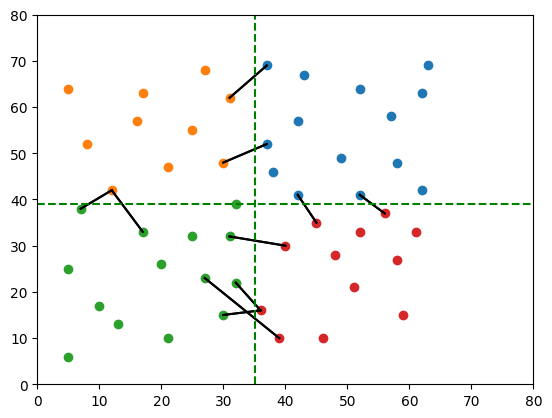

In [1023]:
sys.setrecursionlimit(100)

pairs = []
def recurse_graph(global_array, points_info, transit_point_master, transit_info_master, partition_master, partitions_grid, reference_frame = (None, None, None, None, None, None), ising_size = 12):
    '''
    Given a set of points and transit points (if any), recursively split the graph into 4 quadrants and generate transit points between them.
    points info is either a single element or 4 element list of 3-tuples (points, transit points, ising solvable)
    Iterate through this list, if ising_solvable is False, then split the points into 4 quadrants and generate transit points between them.
    If ising_solvable is True, then move on to the next element in the list.
    x/y_reference frame is a 3-tuple only for visualization purposes. (for the recursive gridding that is happening) 
    '''
    for i, p in enumerate(points_info):
        if p[1] == False:
            p_new, transit_point_master, transit_info_master, x_mid, y_mid = generate_transit_points(global_array, p[0], transit_point_master, transit_info_master, reference_frame, ising_size)
            
            x_ref, x_ref_min, x_ref_max, y_ref, y_ref_min, y_ref_max = reference_frame
     
            if i == 0:
                x_lim_1 = y_ref
                x_lim_2 = x_ref_max
                y_lim_1 = x_ref
                y_lim_2 = y_ref_max
            elif i == 1:
                x_lim_1 = y_ref
                x_lim_2 = x_ref_max
                y_lim_1 = y_ref_min
                y_lim_2 = x_ref
            elif i == 2:
                x_lim_1 = x_ref_min
                x_lim_2 = y_ref
                y_lim_1 = y_ref_min
                y_lim_2 = x_ref
            elif i == 3:
                x_lim_1 = x_ref_min
                x_lim_2 = y_ref
                y_lim_1 = x_ref
                y_lim_2 = y_ref_max
            partitions_grid.append((x_mid, x_lim_1, x_lim_2, y_mid, y_lim_1, y_lim_2))
            transit_point_master, transit_info_master, partitions_grid, partition_master = recurse_graph(global_array, p_new, transit_point_master, transit_info_master, partition_master, partitions_grid, (x_mid, x_lim_1, x_lim_2, y_mid, y_lim_1 ,y_lim_2), ising_size)
        else:
            partition_master.append(p[0])
    return transit_point_master, transit_info_master, partitions_grid, partition_master

partitions_grid = []
transit_point_master = []
transit_info_master = []
partition_master = []

initial_points_info = [(X_Y, False)]

transit_point_master, transit_info_master, partitions_grid, partition_master = recurse_graph(X_Y, initial_points_info, transit_point_master, transit_info_master, partition_master, partitions_grid)
print(partition_master)

In [1024]:
# Find all connected components using DFS
def dfs(node, visited, group, graph):
    visited.add(node)
    group.append(node)
    for neighbor in graph[node]:
        if neighbor not in visited:
            dfs(neighbor, visited, group, graph)

# Identify the endpoints for each chain
def find_endpoints(chain, graph):
    # Count neighbors for each node in the chain
    endpoints = [node for node in chain if len(graph[node]) == 1]
    # Sort the chain with endpoints at the ends
    if len(endpoints) == 2:
        start, end = endpoints
        sorted_chain = []
        visited = set()

        def ordered_dfs(node):
            if node not in visited:
                visited.add(node)
                sorted_chain.append(node)
                for neighbor in graph[node]:
                    if neighbor not in visited:
                        ordered_dfs(neighbor)

        ordered_dfs(start)
        return sorted_chain
    return chain  # If no clear endpoints, return the chain as is

def group_chained_links_with_endpoints(sublists):
    # Build a graph from the sublists
    graph = defaultdict(set)
    for a, b in sublists:
        graph[a].add(b)
        graph[b].add(a)

    # Get all chains (connected components)
    visited = set()
    chains = []
    for node in graph:
        if node not in visited:
            group = []
            dfs(node, visited, group, graph)
            chains.append(group)


    # Sort chains with endpoints
    result = [find_endpoints(chain, graph) for chain in chains]
    return result

def remove_reverse_links(l):
    #remove l1-l2 if l2-l1 is present in transit_point_master
    seen = set()
    l_new = []

    for sublist in l:
        # Create a sorted tuple to represent the pair
        pair = tuple(sorted(sublist))
        
        # Add to the result only if this pair hasn't been added before
        if pair not in seen:
            seen.add(pair)
            l_new.append(sublist)
    return l_new

In [1025]:
def rearrange_sublists(X_Y, transit_point_master_new):
    # Initialize variables to track the required sublists
    first_sublist = None
    last_sublist = None

    # Track the smallest x and y coordinates and their respective sublists
    min_x = float('inf')
    min_y = float('inf')

    # Iterate through each sublist to find the required sublists
    for sublist in transit_point_master_new:
        for idx in sublist:
            x, y = X_Y[idx]  # Extract the x, y coordinates from X_Y using the index

            if x < min_x:  # Update if a smaller x-coordinate is found
                min_x = x
                first_sublist = sublist

            if y < min_y:  # Update if a smaller y-coordinate is found
                min_y = y
                last_sublist = sublist

    # Remove the identified sublists from the main list
    transit_point_master_new.remove(first_sublist)
    if first_sublist != last_sublist:  # Avoid duplication if they are the same
        transit_point_master_new.remove(last_sublist)
    
    if X_Y[first_sublist[0]][0] > X_Y[first_sublist[1]][0]:
        first_sublist = first_sublist[::-1]
    
    if X_Y[last_sublist[0]][1] < X_Y[last_sublist[1]][1]:
        last_sublist = last_sublist[::-1]     

    # Rearrange the list
    transit_point_master_new.insert(0, first_sublist)  # Add the first sublist at the beginning
    transit_point_master_new.append(last_sublist)     # Add the last sublist at the end

    return transit_point_master_new

In [1026]:
'''
# Helper function to calculate distance from point to line segment
def distance_to_line(point, coord1, coord2):
    v1 = coord2 - coord1
    v2 = point - coord1
    
    # Project v2 onto v1
    projection_length = np.dot(v2, v1) / np.dot(v1, v1) if np.dot(v1, v1) != 0 else 0
    
    # Check if the projection falls within the line segment
    if projection_length < 0:
        closest_point = coord1
    elif projection_length > 1:
        closest_point = coord2
    else:
        closest_point = coord1 + projection_length * v1
    
    return np.linalg.norm(point - closest_point)
    

def efficient_group_indices(X_Y, partition, available_tps_grouped, ising_size):
    # Create a set of all indices in available_tps_grouped for quick lookup
    used_indices = set()
    for sublist in available_tps_grouped:
        used_indices.add(sublist[0])
        used_indices.add(sublist[1])
    
    # Filter out points that are already in available_tps_grouped
    valid_partition = [p for p in partition if p not in used_indices]

    # Phase 1: Sort points by their "uniqueness"
    point_distances = []
    for point_idx in valid_partition:
        point = X_Y[point_idx]
        distances_to_sublists = []
        for sublist in available_tps_grouped:
            coord1 = X_Y[sublist[0]]
            coord2 = X_Y[sublist[1]]
            dist = distance_to_line(point, coord1, coord2)
            distances_to_sublists.append(dist)
        
        sorted_distances = sorted(distances_to_sublists)
        uniqueness_score = sorted_distances[1] / sorted_distances[0] if sorted_distances[0] > 0 else float('inf')
        point_distances.append((uniqueness_score, point_idx))
    
    point_distances.sort(reverse=True)
    
    # Phase 2: Assign points to groups
    groups = defaultdict(list)
    for _, point_idx in point_distances:
        point = X_Y[point_idx]
        best_distance = float('inf')
        best_group = None
        
        for i, sublist in enumerate(available_tps_grouped):
            if len(groups[i]) >= ising_size:
                continue
            
            coord1 = X_Y[sublist[0]]
            coord2 = X_Y[sublist[1]]
            dist = distance_to_line(point, coord1, coord2)
            
            if dist < best_distance:
                best_distance = dist
                best_group = i
        
        if best_group is not None:
            groups[best_group].append(point_idx)
    
    return groups
'''

from collections import defaultdict
import numpy as np

# Given helper function remains the same
def distance_to_line(point, coord1, coord2):
    v1 = coord2 - coord1
    v2 = point - coord1
    
    # Project v2 onto v1
    denom = np.dot(v1, v1)
    projection_length = np.dot(v2, v1) / denom if denom != 0 else 0.0
    
    # Check if the projection falls within the line segment
    if projection_length < 0:
        closest_point = coord1
    elif projection_length > 1:
        closest_point = coord2
    else:
        closest_point = coord1 + projection_length * v1
    
    return np.linalg.norm(point - closest_point)

def distance_to_sublists(point, sublist, X_Y):
    """Calculate the minimum distance from a point to all pairwise lines formed by a sublist."""
    min_distance = float('inf')
    for i in range(len(sublist)):
        for j in range(i + 1, len(sublist)):
            coord1 = X_Y[sublist[i]]
            coord2 = X_Y[sublist[j]]
            dist = distance_to_line(point, coord1, coord2)
            min_distance = min(min_distance, dist)
    return min_distance

def efficient_group_indices(X_Y, transit_points_ordered, partition, available_tps_grouped, ising_size):
    
    # Create a set of all indices in available_tps_grouped for quick lookup
    used_indices = set()
    for sublist in available_tps_grouped:
        used_indices.update(sublist)

    # Include elements that are in both transit_points_ordered and partition
    transit_points_set = {point for sublist in transit_points_ordered for point in sublist}
    valid_partition = [p for p in partition if (p not in used_indices and p not in transit_points_set)]
    

    # Phase 1: Sort points by their "uniqueness"
    point_distances = []
    for point_idx in valid_partition:
        point = X_Y[point_idx]
        distances_to_sublists = [
            distance_to_sublists(point, sublist, X_Y)
            for sublist in available_tps_grouped
        ]
        
        sorted_distances = sorted(distances_to_sublists)
        uniqueness_score = (
            sorted_distances[1] / sorted_distances[0] 
            if len(sorted_distances) > 1 and sorted_distances[0] > 0 else float('inf')
        )
        point_distances.append((uniqueness_score, point_idx))

    point_distances.sort(reverse=True)

    # Phase 2: Assign points to groups
    groups = defaultdict(list)
    for _, point_idx in point_distances:
        point = X_Y[point_idx]
        best_distance = float('inf')
        best_group = None

        for i, sublist in enumerate(available_tps_grouped):
            if len(groups[i]) >= ising_size:
                continue

            dist = distance_to_sublists(point, sublist, X_Y)
            
            if dist < best_distance:
                best_distance = dist
                best_group = i

        if best_group is not None:
            groups[best_group].append(point_idx)

    # =======================
    # Refinement Step
    # =======================
    def two_closest_points_in_group(point_idx, group_idx):
        point = X_Y[point_idx]
        
        # Start with all points in the group, including the sublist base points
        base_points_indices = available_tps_grouped[group_idx]
        candidate_indices = base_points_indices + [idx for idx in groups[group_idx] if idx != point_idx]
        candidate_coords = X_Y[candidate_indices]
        
        # Compute distances to all candidates
        dists = np.linalg.norm(candidate_coords - point, axis=1)
        
        # Find the two smallest distances
        closest_two = np.partition(dists, 1)[:2]
        return np.sum(closest_two)

    changed = True
    while changed:
        changed = False
        all_assignments = [(g, p) for g, pts in groups.items() for p in pts]

        for current_group, point_idx in all_assignments:
            if point_idx not in groups[current_group]:
                continue

            current_dist_sum = two_closest_points_in_group(point_idx, current_group)

            for new_group in groups.keys():
                if new_group == current_group:
                    continue

                if len(groups[new_group]) >= ising_size:
                    continue

                new_dist_sum = two_closest_points_in_group(point_idx, new_group)

                if new_dist_sum < current_dist_sum:
                    groups[current_group].remove(point_idx)
                    groups[new_group].append(point_idx)
                    changed = True
                    break

    return groups

In [1027]:
def gen_partition_sol(X_Y, base_distance, solution_tree, partition, pid, transit_points_ordered, benchmark, ising_size):
    '''
    Given a partition of points, and the ordered transit points, generate the solution for the partition, insert it into the global solution list
    '''
    available_tps = []
    #special_links = [] #those chains which are not regular tps
    

    if transit_points_ordered[0][0] in partition and transit_points_ordered[-1][-1] in partition:
        available_tps.append(transit_points_ordered[-1][-1])
        available_tps.append(transit_points_ordered[0][0])
        
    
    for i in range(len(transit_points_ordered) - 1):
        first_sublist = transit_points_ordered[i]
        second_sublist = transit_points_ordered[i + 1]
        # Check conditions
        if first_sublist[-1] in partition and second_sublist[0] in partition:
            available_tps.append(first_sublist[-1])
            available_tps.append(second_sublist[0])
    
    #print(available_tps)
    #group the available_tps into twos
    available_tps_grouped = [available_tps[i:i+2] for i in range(0, len(available_tps), 2)]
    #print(available_tps_grouped)
    #print(special_links)
    grouped_partition = efficient_group_indices(X_Y, transit_points_ordered, partition, available_tps_grouped, ising_size)
    for i, sl in enumerate(available_tps_grouped):
        
        '''
        plt.scatter(X_Y[sl[0]][0], X_Y[sl[0]][1], color='black')
        plt.scatter(X_Y[sl[1]][0], X_Y[sl[1]][1], color='black')
        plt.text(X_Y[sl[0]][0], X_Y[sl[0]][1], f'{pid}_{i}')
        plt.text(X_Y[sl[1]][0], X_Y[sl[1]][1], f'{pid}_{i}')
        '''
        
        if grouped_partition[i] == []:
            continue
        elif len(grouped_partition[i]) != 1:
            
            '''
            color = np.random.rand(3,)
            for p in grouped_partition[i]:
                plt.scatter(X_Y[p][0], X_Y[p][1], color=color)
            '''
            
            cpp_cmd = "./ising_mac_macos"
            curr_filename = str(benchmark) + "_partition" + str(pid) +'_'+ str(i)+ ".in"
            curr_logfile = str(benchmark) + "_partition" +str(pid)+'_'+ str(i)+".out"
            inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
            inF.write(str(2+len(grouped_partition[i])))
            inF.write("\n")
            inF.write(str(X_Y[sl[0]][0]) + " " + str(X_Y[sl[0]][1]) + " " + str(sl[0]) + "\n")
            #inF.write(str(X_Y[sl[0]][0]) + " " + str(X_Y[sl[0]][1]) + "\n")
            for p in grouped_partition[i]:
                inF.write(str(X_Y[p][0]) + " " + str(X_Y[p][1]) + " " + str(p) + "\n")
                #inF.write(str(X_Y[p][0]) + " " + str(X_Y[p][1])+ "\n")
            
            inF.write(str(X_Y[sl[1]][0]) + " " + str(X_Y[sl[1]][1]) + " " + str(sl[1]) + "\n")
            #inF.write(str(X_Y[sl[1]][0]) + " " + str(X_Y[sl[1]][1]) + "\n")
            
            inF.close()
            os.system(cpp_cmd+ " k2" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            
            #solve the ising problem, insert solution between the 2 points in solution tree

            with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile, "r") as outFile:
                lines = outFile.readlines()
                sublist = [] 
                for i in range(len(lines)):
                    line = lines[i].strip()  # Strip leading/trailing whitespace
                    if not line:  # Skip empty lines
                        continue
                    if "dist" in line:
                        base_distance += float(line.split()[1])  # Extract value after "dist"
                        continue
                    if "n_MAC" in line:
                        #nMAC_array.append(int(line.split()[1]))  # Extract and append integer value
                        continue
                    if "n_RandFlip" in line:
                        #nRandFlip_array.append(int(line.split()[1]))  # Extract and append integer value
                        continue
                    # Add the line to the sublist if it passes all conditions
                    sublist.append(int(float(line.split()[2])))      
            ind1 = solution_tree.index(sl[0])
            ind2 = solution_tree.index(sl[1])
        
            if ind1 < ind2:
                if ind2 == len(solution_tree) - 1:
                    solution_tree += sublist[1:-1]
                else:
                    solution_tree[ind2:ind2] = sublist[1:-1]
            else:
                if ind1 == len(solution_tree) - 1:
                    solution_tree += sublist[1:-1] #maybe extraneous code?
                else:
                    solution_tree[ind1:ind1] = sublist[1:-1]
            #print(sl[0], sl[1])
            #print(solution_tree)
        elif len(grouped_partition[i]) == 1:
            #just add the point to the solution tree, between the 2 points
            ind1 = solution_tree.index(sl[0])
            ind2 = solution_tree.index(sl[1])
            if ind1 < ind2:
                solution_tree.insert(ind1+1, grouped_partition[i][0])
            else:
                solution_tree.insert(ind2+1, grouped_partition[i][0]) 
            base_distance += np.linalg.norm(X_Y[sl[0]] - X_Y[grouped_partition[i][0]]) + np.linalg.norm(X_Y[sl[1]] - X_Y[grouped_partition[i][0]])   
            #print(sl[0], sl[1])
            #print(solution_tree) 
        #print('end')   
    return solution_tree, base_distance
    

In [1028]:
def total_distance_in_sublists(sublists, X_Y):
    """
    Calculates the total distance between elements in sublists based on coordinates in X_Y.
    """

    if not sublists:
        return 0

    total_distance = 0

    for sublist in sublists:
        if len(sublist) < 2:
            raise ValueError("Sublists must contain at least two elements.")

        # Calculate distances within the sublist
        for i in range(len(sublist) - 1):
            index1 = sublist[i]
            index2 = sublist[i + 1]

            coord1 = X_Y[index1]
            coord2 = X_Y[index2]
            distance = np.linalg.norm(coord2 - coord1)  # Euclidean distance
            total_distance += distance
    
    total_distance += np.linalg.norm(X_Y[sublists[-1][-1]] - X_Y[sublists[0][0]])  # Add the distance between the last and first elements

    return total_distance

def gen_hierarchical_sol(global_X_Y, partition_master, transit_point_master, benchmark, ising_size = 12):
    '''
    given partitions (expecting points in a quadrant and the transit points within that quadrant) and transit_point_master
    first Ising-solve transit_point_master, then for each partition, group all the points to nearest transit point with capacity
    and ising solve all points within each partition.
    '''
    #first ising solve transit_point_master (if it is greater than 12 we need to do the entire thing again)
    #for now, lets assume size of transit_point_master is less than 12, we will add the recursive part later

    transit_point_master_new = rearrange_sublists(global_X_Y, group_chained_links_with_endpoints(remove_reverse_links(transit_point_master)))
    print(transit_point_master_new)
    #print(transit_point_master_new)

    if len(transit_point_master_new) > ising_size or len(transit_point_master_new) < 3:
        raise ValueError("Transit point master is too large/small to be ising solved")
    else:
        #ising solve transit_point_master
        
        #cpp_cmd = "./ising_mac_transit_macos" #special case, where distance b/w consecutive points is set to 0
        #TODO CRITICAL: fix the logic of of the tp-ising solver to support tp-chains
        cpp_cmd = "./ising_mac_transit_custom"
        os.system("rm -rf sys2clusters_" + str(benchmark))
        os.system("mkdir -p sys2clusters_" + str(benchmark))
        curr_filename = str(benchmark) + "transit_point" + ".in"
        curr_logfile = str(benchmark) + "transit_point" + ".out"
        inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
        inF.write(str(2*len(transit_point_master_new)))
        inF.write("\n")
        for sublist in transit_point_master_new:
            # Write the first and last element of the sublist
            inF.write(str(global_X_Y[sublist[0], 0]) + " " + str(global_X_Y[sublist[0], 1]))
            #check which partition sublist[0] belongs to
            index = next((i for i, arr in enumerate(partition_master) if sublist[0] in arr), None)
            inF.write(" " + str(index))
            inF.write("\n")
            inF.write(str(global_X_Y[sublist[-1], 0]) + " " + str(global_X_Y[sublist[-1], 1]))
            index = next((i for i, arr in enumerate(partition_master) if sublist[-1] in arr), None)
            inF.write(" " + str(index))
            inF.write("\n")
        inF.close()
        
        
        #os.system(cpp_cmd+ " k2" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
        os.system(cpp_cmd+ " sys2clusters_" + str(benchmark) + "/" + curr_filename)
        
        dist_array = []
        nMAC_array = []
        nRandFlip_array = []
        tp_ordered = []
        with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile, "r") as outFile:
            lines = outFile.readlines()
            for i in range(len(lines)):
                sublist = []  # Temporary list to store valid lines for the current sublist
                line = lines[i].strip()  # Strip leading/trailing whitespace
                if not line:  # Skip empty lines
                    continue
                if "dist" in line:
                    dist_array.append(line.split()[1])  # Extract value after "dist"
                    continue
                if "n_MAC" in line:
                    nMAC_array.append(int(line.split()[1]))  # Extract and append integer value
                    continue
                if "n_RandFlip" in line:
                    nRandFlip_array.append(int(line.split()[1]))  # Extract and append integer value
                    continue
                # Add the line to the sublist if it passes all conditions
                sublist.append(int(float(line.split()[0])))
                sublist.append(int(float(line.split()[1])))   

                # Append the sublist to tp_ordered if it has any lines
                if sublist:
                    tp_ordered.append(sublist)
        
        #print(tp_ordered)
        
        
        #plot for debug
        
        plt.figure()
        for i in range(0, len(tp_ordered) - 1): 
            
            plt.plot([tp_ordered[i][0], tp_ordered[i+1][0]], [tp_ordered[i][1], tp_ordered[i+1][1]], 'black') 
            plt.scatter([tp_ordered[i][0], tp_ordered[i+1][0]], [tp_ordered[i][1], tp_ordered[i+1][1]], color='red')
        
        
        
        tp_ordered_indices_grouped = []
        for i in range(0, len(tp_ordered) - 1, 2):
            first_sublist = tp_ordered[i]
            second_sublist = tp_ordered[i + 1]
            # Check membership in transit_point_master_new
            flag = 0
            for sublist in transit_point_master_new:
                #print(first_sublist, second_sublist)
                #print(sublist)
                #print('end')
                if (np.array_equal(global_X_Y[sublist[0]], np.array(first_sublist)) and np.array_equal(global_X_Y[sublist[-1]], np.array(second_sublist))):
                    tp_ordered_indices_grouped.append(sublist)
                    flag = 1
                    break
                elif (np.array_equal(global_X_Y[sublist[-1]], np.array(first_sublist)) and np.array_equal(global_X_Y[sublist[0]], np.array(second_sublist))):
                    tp_ordered_indices_grouped.append(sublist[::-1])
                    flag = 1
                    break
            if flag == 0:
                raise ValueError("Invalid transit point ising solution")
        
        

        
        solution_tree = [item for sublist in tp_ordered_indices_grouped for item in sublist]
        #print(solution_tree)
        base_distance = total_distance_in_sublists(tp_ordered_indices_grouped, global_X_Y)
        #print(base_distance)
        

        
        '''
        plt.figure()
        plt.xlim(0, 75)
        plt.ylim(0, 75)
        '''

        #print(solution_tree)
        for i, p in enumerate(partition_master):
            solution_tree, base_distance = gen_partition_sol(global_X_Y, base_distance, solution_tree, p, i, tp_ordered_indices_grouped, benchmark, ising_size)
        
        return solution_tree, base_distance

[[24, 13], [26, 45], [30, 25], [7, 21], [10, 37], [15, 49], [4, 36], [14, 43]]


np.float64(466.8134314352971)

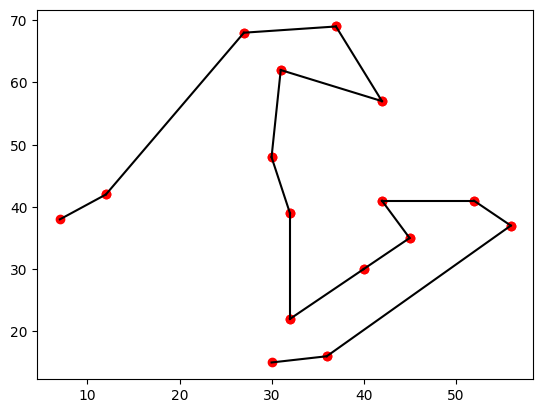

In [1029]:
tp_placeholder = [[24, 13], [13, 24], [26, 45], [45, 26], [30, 25], [25, 30], [7, 21], [21, 7], [10, 37], [37, 10], [15, 49], [49, 15], [43, 14], [14, 43], [4, 36], [36, 4]]
#tp_placeholder = [[24, 13], [13, 24], [13, 17], [17, 13], [30, 25], [25, 30], [7, 21], [21, 7], [10, 37], [37, 10], [15, 49], [49, 15], [43, 14], [14, 43], [4, 36], [36, 4]]


sol, dist = gen_hierarchical_sol(X_Y, partition_master, tp_placeholder, x, 12)
dist

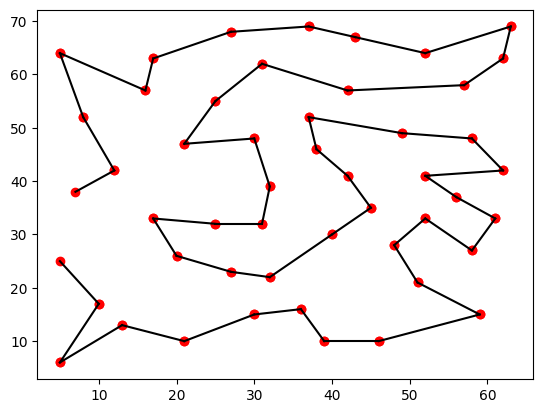

In [1030]:
plt.figure()
for i in range(0, len(sol) - 1): 
    plt.plot([X_Y[sol[i]][0], X_Y[sol[i+1]][0]], [X_Y[sol[i]][1], X_Y[sol[i+1]][1]], 'black') 
    plt.scatter([X_Y[sol[i]][0], X_Y[sol[i+1]][0]], [X_Y[sol[i]][1], X_Y[sol[i+1]][1]], color='red')
plt.show()

In [ ]:
## sys2_cities has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster, Cities X/Y coordinates in the sub-cluster]
## sys2_centers has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster]
## sys2_clusters has [hierarchies where the sub-cluster belongs, Cities X/Y coordinates in the sub-cluster]
sys2_centers = []
sys2_clusters = []

H = range(0,len(hierarchies))
for h in H:
    K = range(0,hierarchies[h])
    sys2_centers.append([])
    sys2_clusters.append([])
    colors = mpl.cm.tab20(range(20))
    for k in K:
        sys2_centers[h].append(X_Y[h+1][k])
        sys2_clusters[h].append(X_Y[h][get_clustered_cities(k, KM_labels[h])])
    largest_cluster_size = 0
    smallest_cluster_size = 100
    for k in K:
        if len(sys2_clusters[h][k]) > largest_cluster_size:
            largest_cluster_size = len(sys2_clusters[h][k])
        if len(sys2_clusters[h][k]) < smallest_cluster_size:
            smallest_cluster_size = len(sys2_clusters[h][k])
        if (len(sys2_clusters[h][k]) == 1):
            print("dirty cluster")
    print("The largest & smallest cluster size in Hierarchy ",h+1, ": ", largest_cluster_size, " & ", smallest_cluster_size)
## Add the topmost cluster
sys2_centers.append([])
sys2_clusters.append([])
sys2_centers[-1].append([0, 0])
sys2_clusters[-1].append(X_Y[-1])

dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty cluster
dirty 

In [ ]:
def Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, Lowest_Hier):
    ## Find a pair of the closest cities, each of which is in a distinct cluster which will be sequentially visited.
    ## After finding, place each city of the pair in the end of the preceding cluster and the start of the following cluster.
    ## To avoid the city in the following cluster to be selected once again for the next search, the next search starts from Index 1.
    ## Refer to Page 25
    tree = cKDTree(sys2_centers)
    clust_id_list = []
    total_traveling_distance = 0
    
    for k in range(len(sol_route)-1):
        ## Finding a pair of cities from distinct sub-clusters having the shortest distance betweeen sub-clusters.
        clust_idx_curr = tree.query(sol_route[k])[1]
        clust_idx_next = tree.query(sol_route[k+1])[1]
        if k ==0:
            clust_id_list.append(clust_idx_curr)
        clust_id_list.append(clust_idx_next)
        
        curr_clust = sys2_clusters[clust_idx_curr]
        next_clust = sys2_clusters[clust_idx_next]
        tree_clust = cKDTree(next_clust)
        ## For the first cluster in a hierarchy, all cities in the cluster is included in the search.
        ## For clusters that include only one city, the city that has been chosen for the first city from the previous search 
        ## will be used for the search and chosen for the last city. The first and last city at the same time. 
        if k ==0 or len(curr_clust) == 1:
            search_init = 0
        ## Otherwise, the first city is excluded from the search, because it's already chosen for the first city.
        else:
            search_init = 1
        sht_dist = inf
        for inc in range(search_init, len(curr_clust)):
            val_sd, idx_sd = tree_clust.query(curr_clust[inc])
            if val_sd < sht_dist:
                sht_dist = val_sd
                sht_idx_curr = inc
                sht_idx_next = idx_sd
                
        ## Fix the first and the last cities according to the information found above, unless the clust has one city.
        if len(curr_clust) > 1:
            curr_clust[[-1, sht_idx_curr]] = curr_clust[[sht_idx_curr,-1]]
            sys2_clusters[clust_idx_curr] = curr_clust
        if len(next_clust) > 1:
            next_clust[[0, sht_idx_next]] = next_clust[[sht_idx_next,0]]
            sys2_clusters[clust_idx_next] = next_clust
        if Lowest_Hier:
            total_traveling_distance += sht_dist
            #print("Inter-cluster distance (clusters ", k, "-", k+1, "): ", sht_dist, " total distance: ", total_traveling_distance)
            
    return sys2_clusters, clust_id_list, total_traveling_distance

In [ ]:
def skip_ising(Lowest_Hier, hier, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, infile, outfile):
    #print("Ising skipped!!")
    timet[-1].append(0)
    nMAC_array[-1].append(0)
    nRandFlip_array[-1].append(0)
    DIST = 0
    with open(infile,"r") as inF:
        lines = inF.readlines()
        outF = open(outfile,"w")
        
        for i in range(1, curr_clust_size+1):
            line = lines[i]
            outF.write(line)
            
            curr = line.strip().split()
            for j in range(len(curr)):
                curr[j] = float(curr[j])
            sol_route.append(curr)
            
            '''
            if Lowest_Hier:
                if (i == 1):
                    route_btw_clusters.append(curr)
                if (i == curr_clust_size):
                    route_btw_clusters.append(curr)
            '''
            if (i == 1):
                    route_btw_clusters[hier].append(curr)
            if (i == curr_clust_size):
                    route_btw_clusters[hier].append(curr)
        if curr_clust_size == 1:
            DIST = 0
        else:
            for i in range(1, curr_clust_size):
                X1 = float(lines[i].strip().split()[0])
                Y1 = float(lines[i].strip().split()[1])
                X2 = float(lines[i+1].strip().split()[0])
                Y2 = float(lines[i+1].strip().split()[1])
                DIST += sqrt((X1-X2)**2+(Y1-Y2)**2)
        outF.write("\n")
        outF.write("dist ")
        outF.write(str(DIST))
        outF.write("\n")
        outF.write("n_MAC 0")
        outF.write("\n")
        outF.write("n_RandFlip 0")
        outF.write("\n")
        
        outF.close()
        inF.close()

        if Lowest_Hier:
            total_traveling_distance += DIST
    
    return total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array

In [ ]:
def gen_sys2_sol(MAC_ising, benchmark, sys2_centers, sys2_clusters, SchPar):
    MAC_ising = True
    if MAC_ising:
        cpp_cmd = "./ising_mac3"
    else :
        cpp_cmd = "./ising_RNG"
    os.system("rm -rf sys2clusters_" + str(benchmark))
    SYS2_CENTERS = sys2_centers
    SYS2_CLUSTERS = sys2_clusters
    
    timet =[]
    nMAC_array =[]
    nRandFlip_array = []
    sys2_labels = []
    colors = mpl.cm.tab20(range(20))
    sol_route = 0
    sol_route_ex = []
    
    ideal_latency = 0
    nMAC_hierarchies = []
    route_btw_clusters = [[] for _ in range(n_hierarchies+1)]
  
    for h in range(0, n_hierarchies+1):
        print("Execute Ising Solver for Hierarchy ", n_hierarchies-h)
        sys2_centers = SYS2_CENTERS[n_hierarchies-h]
        sys2_clusters = SYS2_CLUSTERS[n_hierarchies-h]

        if h != 0:
            tic = time.perf_counter()
            sys2_clusters, clust_id_list, total_traveling_distance = Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, h == n_hierarchies)
            toc = time.perf_counter()
            print("Fixing time:", toc-tic)
        else:
            clust_id_list = range(0, len(sys2_centers))
            
        sol_route_ex.append(sol_route)
        sol_route = []
        
        timet.append([])
        nMAC_array.append([])
        nRandFlip_array.append([])
        sys2_labels.append([])
        
        for k in range(len(clust_id_list)):
            curr_clust = sys2_clusters[clust_id_list[k]]
            curr_clust_size = len(curr_clust)
            for l in range(curr_clust_size):
                sys2_labels[h].append(colors[k%20])
            os.system("mkdir -p sys2clusters_" + str(benchmark))
            curr_filename = str(benchmark) + "_h" + str(n_hierarchies-h)  + "_c" + str(k) +".in"
            curr_logfile = str(benchmark) + "_h" + str(n_hierarchies-h)   + "_c" + str(k) +".out"
            inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
            inF.write(str(curr_clust_size))
            inF.write("\n")
            for i in curr_clust:
                inF.write(str(i[0]) + " " + str(i[1]))
                inF.write("\n")
            inF.close()
            
            if h == 0:
                if curr_clust_size == 2:
                    total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, 0, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                    continue
            else:
                if k == 0 or k == len(clust_id_list)-1:
                    if curr_clust_size < 3:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
                else:
                    if curr_clust_size < 4:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, h, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
            tic = time.perf_counter()
            ### when h>0, Problem_size to optimize = N-1 when k is 0 or -1, otherwise N-2
            if h == 0 :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k0" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            elif k == len(clust_id_list)-1:
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k-1" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            else :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k" + str(k+1) + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            toc = time.perf_counter()
            timet[-1].append(toc-tic)
            
            dist_array =[]
            with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile,"r") as outFile:
                lines = outFile.readlines()
                for i in range(0,len(lines)):
                    line = lines[i]
                    if "dist" in line:
                        dist_array.append(line.strip().split()[1])
                        continue
                    if "n_MAC" in line:
                        nMAC_array[-1].append(int(line.strip().split()[1]))
                        continue
                    if "n_RandFlip" in line:
                        nRandFlip_array[-1].append(int(line.strip().split()[1]))
                        continue
                dist = min(dist_array)
                ####################################
                ####################################
                if h == n_hierarchies:
                    total_traveling_distance += float(dist)
                    print("hierarchy: ", h, " cluster: ", k, " distance within the cluster: ", float(dist), " total distance: ", total_traveling_distance)
                ####################################
                ####################################
                for i in range(0, curr_clust_size):
                    line = lines[i]
                    curr = line.strip().split()
                    for j in range(len(curr)):
                        curr[j] = float(curr[j])
                    sol_route.append(curr)
                
                    '''
                    if h == n_hierarchies:
                        if (i == 0) or (i == curr_clust_size-1):
                            route_btw_clusters.append(curr)
                    '''
                    if (i == 0) or (i == curr_clust_size-1):
                        print('HERE', h, curr)
                        route_btw_clusters[h].append(curr)
                
                outFile.close()
            #print("done with cluster" + str(k))
        ideal_latency += max(timet[-1])
        nMAC_hierarchies.append(max(nMAC_array[-1]))
        if MAC_ising:
            print(f"Max/Min number of Ising Macro MAC Operations = ", max(nMAC_array[-1]), " / ", min(nMAC_array[-1]))

            
    #print("total wall-clock latency: ", ideal_latency)
    #print("Max nMAC per hierarchy: ", nMAC_hierarchies)
    #print("total traveling distance: ", total_traveling_distance)
    return sol_route_ex, sol_route, route_btw_clusters, sys2_labels, total_traveling_distance, nMAC_array, nRandFlip_array, test

In [ ]:
print(hierarchies)
n_hierarchies = len(hierarchies)
MAC_ising = True
"""
        if h==0:
            print(sys2_clusters)
Thresholds = [0]
Patiences = [30]

init_Irands = [420]
init_cools = [0.1, 0.05, 0.01]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]
"""
init_Irands = [420]
init_cools = [0.05]
Factors = [0.4]
Thresholds = [0]
Patiences = [1]

#cools = [0.01, 0.005, 0.002, 0.001]
#Factors = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
#Thresholds = [1e6, 1e3, 0, -1e3, -1e6]
#Patiences = [5, 10, 20, 50]
ttds = []
nMACs = []
nRandFlips = []

repeat = 1

for REPEAT in range(repeat):
    i = 0
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        scheduler_params = [Irand, cool, Factor, Threshold, Patience]
                        sol_route_ex, sol_route, route_btw_clusters, sys2_labels, ttd, nMAC, nRandFlip, test = gen_sys2_sol(MAC_ising, x, sys2_centers, sys2_clusters, scheduler_params)
                        ttds.append(ttd)
                        sum_nMACs = 0
                        for MAC in nMAC:
                            sum_nMACs += max(MAC)
                        #nMACs.append(max(nMAC[-1]))
                        nMACs.append(sum_nMACs)
                        sum_nRFlips = 0
                        for RFlip in nRandFlip:
                            sum_nRFlips += max(RFlip)
                        #nRandFlips.append(max(nRandFlip[-1]))
                        nRandFlips.append(sum_nRFlips)
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
    """
hierarchies_new = []
for XX in range(len(Cluster_distribution)):
    hierarchies_new.append(sum(Cluster_distribution[XX].values()))
    kick_out = []
    for key, value in Cluster_distribution[XX].items():
        if value == 0:
            kick_out.append(key)
    for key in kick_out:
        del Cluster_distribution[XX][key]
print(hierarchies_new)
print(Cluster_distribution)

[261, 261]
Execute Ising Solver for Hierarchy  2


In [ ]:
'''
import math

Istop = -math.log(100/0.5-1)+50
print(Istop)

for Irand in init_Irands:
	for cool in init_cools:
		total_step = int((Irand - Istop) / cool)
		x = []
		for step in range(total_step):
			x.append(step)
		for Factor in Factors:
			for Threshold in Thresholds:
				for Patience in Patiences:
					y = []
					DD = ceil(total_step/Patience)
					for step in range(total_step):
						#y.append(45.4 + pow(Factor,floor(step/DD))*(Irand-45.4)*0.5*(math.cos(((step % DD)/DD)*3.14)+1))
						#y.append(Irand - ((Irand-45.4)/DD)*(step%DD))
						IMAX = Irand - Factor*floor(step/DD)
						y.append(IMAX - ((IMAX-Istop-Factor*(Patience-1-floor(step/DD)))/DD)*(step%DD))
					plt.plot(x,y)
plt.axhline(y=Istop)
#plt.legend()
plt.show()
'''

'\nimport math\n\nIstop = -math.log(100/0.5-1)+50\nprint(Istop)\n\nfor Irand in init_Irands:\n\tfor cool in init_cools:\n\t\ttotal_step = int((Irand - Istop) / cool)\n\t\tx = []\n\t\tfor step in range(total_step):\n\t\t\tx.append(step)\n\t\tfor Factor in Factors:\n\t\t\tfor Threshold in Thresholds:\n\t\t\t\tfor Patience in Patiences:\n\t\t\t\t\ty = []\n\t\t\t\t\tDD = ceil(total_step/Patience)\n\t\t\t\t\tfor step in range(total_step):\n\t\t\t\t\t\t#y.append(45.4 + pow(Factor,floor(step/DD))*(Irand-45.4)*0.5*(math.cos(((step % DD)/DD)*3.14)+1))\n\t\t\t\t\t\t#y.append(Irand - ((Irand-45.4)/DD)*(step%DD))\n\t\t\t\t\t\tIMAX = Irand - Factor*floor(step/DD)\n\t\t\t\t\t\ty.append(IMAX - ((IMAX-Istop-Factor*(Patience-1-floor(step/DD)))/DD)*(step%DD))\n\t\t\t\t\tplt.plot(x,y)\nplt.axhline(y=Istop)\n#plt.legend()\nplt.show()\n'

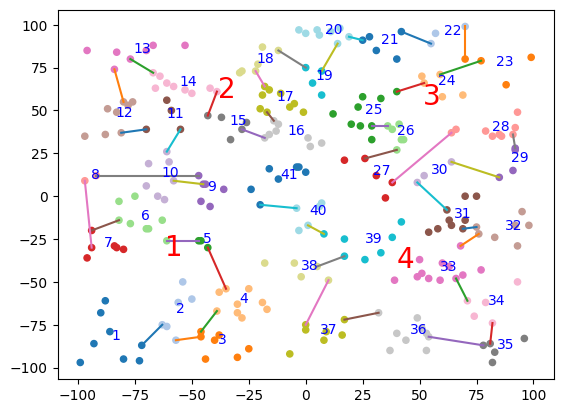

In [ ]:
if True:

    route = np.array(route_btw_clusters[n_hierarchies])
    sol_route = np.array(sol_route)
    for n in range(int(len(route_btw_clusters[n_hierarchies])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    plt.scatter(sol_route[:,0], sol_route[:,1], c=sys2_labels[n_hierarchies][:], s=20)

    colors = 'rbk'
    sol_route_ex = sol_route_ex[1:]

    for H in range(len(sol_route_ex)):
        for n in range(len(sol_route_ex[H])):
            plt.text(sol_route_ex[H][n][0],sol_route_ex[H][n][1], str(n+1), fontsize = 10*(len(sol_route_ex)-H), color = colors[H])
    plt.show() 

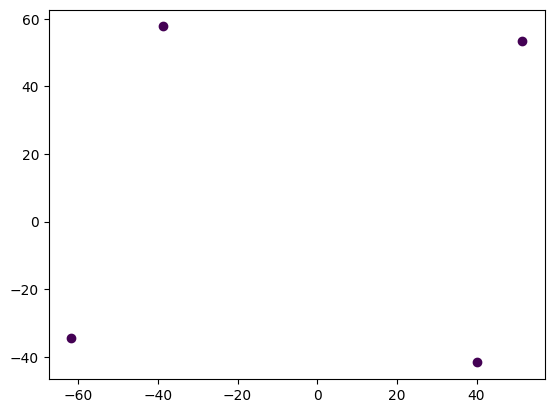

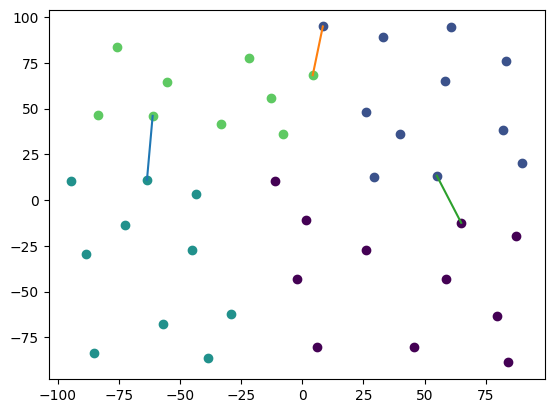

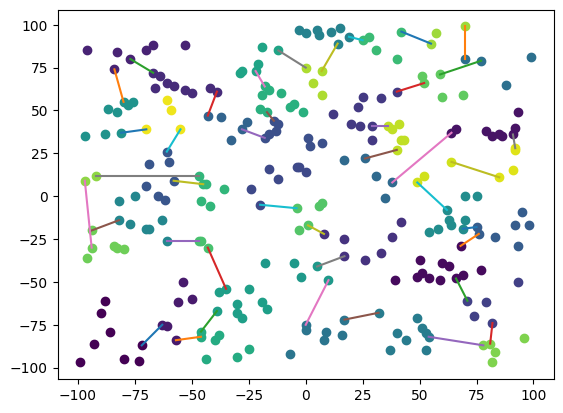

In [ ]:
for h in range(n_hierarchies+1):
    plt.figure()
    cmap = plt.cm.viridis
    route = np.array(route_btw_clusters[h])
    for n in range(int(len(route_btw_clusters[h])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    num_iters = len(sys2_clusters[n_hierarchies - h])
    colors = [cmap(i/num_iters) for i in range(num_iters)]
    iter = 0
    for k in range(len(sys2_clusters[n_hierarchies - h])):
        plt.scatter(sys2_clusters[n_hierarchies - h][k][:,0], sys2_clusters[n_hierarchies - h][k][:,1], color = colors[iter])
        iter+=1

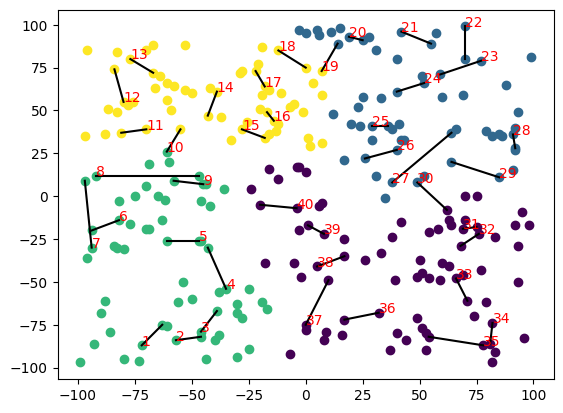

In [ ]:
colors_indices = np.zeros(len(sys2_clusters[0]))
cmap = plt.cm.viridis
for group_idx, group_indices in enumerate(sys2_clusters[1]):
    for center_idx in group_indices:  # Each index corresponds to a sublist in clusters[0]
        colors_indices[next(i for i, elem in enumerate(sys2_centers[0]) if np.array_equal(elem, center_idx))] = group_idx
colors = cmap(colors_indices/ max(colors_indices))
for idx, l in enumerate(sys2_clusters[0]):
    for point in l:
        plt.scatter(point[0], point[1], color = colors[idx])
for n in range(int(len(route_btw_clusters[2])/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-', c='black')
        plt.text(route[2*n+1,0], route[2*n+1,1], str(n+1), fontsize = 10, color = 'red')

In [190]:
from math import sin, cos, sqrt, atan2, radians
def compute_geo(p1,p2):
    R = 6373.0
    
    lat1 = radians(float(p1[0]))
    lon1 = radians(float(p1[1]))
    lat2 = radians(float(p2[0]))
    lon2 = radians(float(p2[1]))
    
    dlon = lon2 - lon1
    dlat = lat2 -lat1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    dist = R*c
    return dist

In [191]:
coord_geo == False
if coord_geo == True:
#     test = np.load("sys2clusters_" + str(x) + "/sol_table.npy", allow_pickle=True)
    for i in range(len(test)):
        print(i)
        for j in range(len(test[i])):
            geo_dist = 0
            li = test[i][j][1]
            for idx,elem in enumerate(li):
                thiscity = elem
                nextcity = li[(idx+1)%len(li)]
                geo_dist += compute_geo(thiscity, nextcity)
            test[i][j][2] = geo_dist 
            print(geo_dist)
        np.save("sys2clusters_" + str(x) + "/sol_table" ,test)    


mport pdb; pdb.set_trace()     

In [926]:
## Sangmin edited
GO = True   
if GO:
    with open("tsp" + x + "_pyconcorde.txt", "w") as f:
        solver = TSPSolver.from_data(X_coord, Y_coord, norm="EUC_2D")  
        solution = solver.solve()
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str("solution found? ") + str(solution.found_tour) + str(" ") )
        f.write( str("Optimal value? ") + str(solution.optimal_value) + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )

NameError: name 'TSPSolver' is not defined

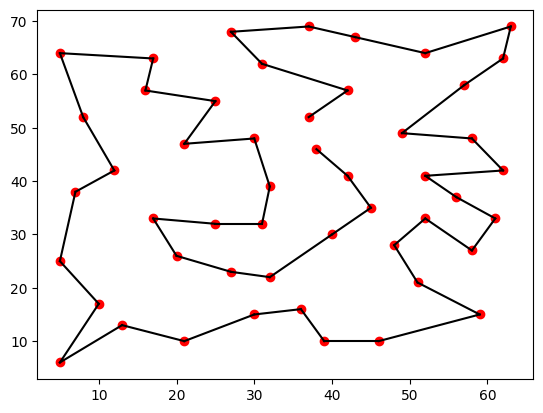

In [195]:
for idx, position in enumerate(solution.tour):
    plt.scatter(X_coord[position], Y_coord[position], c = 'red')
    if idx != len(solution.tour)-1:
        plt.plot([X_coord[position], X_coord[solution.tour[idx+1]]], [Y_coord[position], Y_coord[solution.tour[idx+1]]], c = 'black')

In [ ]:
distance = 0
for i in range(len(solution.tour) - 1):
    distance += np.linalg.norm(X_Y[solution.tour[i]] - X_Y[solution.tour[i+1]])
distance += np.linalg.norm(X_Y[solution.tour[-1]] - X_Y[solution.tour[0]])
distance

422.0186531493204

In [ ]:
GO = False
if GO:
    num_samples = 10000
    set_nodes_coord = np.random.random([num_samples, n_clusters, 2])
    with open("tsp" + str(n_clusters) + "_pr1002.txt", "w") as f:
        solver = TSPSolver.from_data(centers[:,0], centers[:,1], norm="EUC_2D")  
        solution = solver.solve()
        f.write( " ".join( str(x)+str(" ")+str(y) for x,y in centers) )
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )
        